In [2]:
import autograd
import autograd.numpy as anp
from datetime import datetime
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.signal import resample
import torch
import torch.nn.functional as F
from tqdm import tqdm

from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_hr
)

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [4]:
def get_predicted_peaks(signal):
    return get_peaks_v2(signal, 64, 3.0, -1, prominence = 0.3, with_min_dist = True, with_valleys = False)
def get_true_peaks(signal):
    return get_peaks_v2(signal, 64, 3.0, -1, prominence = 0, with_min_dist = True, with_valleys = False)

def _process(targs, signal, smoothing_window = 10, use_bandpass = False):
    
    orig_len = len(signal)
    signal = n_moving_avg(signal, smoothing_window)
    signal = resample(signal, orig_len)
    if use_bandpass:
        signal = bandpass(signal, 64, [0.67, 3.0], 4)
    signal = min_max_scale(signal)
    
    targs = n_moving_avg(targs, 20)
    targs = resample(targs, orig_len)
    targs = min_max_scale(targs)
    
    return targs, signal

In [48]:
from joblib import Parallel, delayed
import multiprocessing
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean

def LossFactory(n, split_size, loss_type = 'mse'):
    epsilon = 1e-8

    def mse_loss(y_pred, data):
        
        y_true = data.get_label()
        num_batches = int(n / split_size)
        errs = np.zeros_like(y_true)

        for i in range(num_batches):
            
            y_true_curr = y_true[i * split_size: (i + 1) * split_size]
            y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
            err = y_true_curr - y_pred_curr
            errs[i * split_size: (i + 1) * split_size] = err

        grad = -2 * errs
        hess = 2 * np.ones_like(y_true)
        return grad, hess
    
    def dot_product_loss(y_pred, data):
        
        
        y_true = data.get_label()
        num_batches = int(n / split_size)
        grads = np.zeros_like(y_true)
        hesses = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * split_size: (i + 1) * split_size]
            y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
            y_true_normalized = y_true_curr / (np.linalg.norm(y_true, axis=-1, keepdims=True) + epsilon)
            y_pred_normalized = y_pred_curr / (np.linalg.norm(y_pred, axis=-1, keepdims=True) + epsilon)
        
            dot_product = np.sum(y_true_normalized * y_pred_normalized, axis=-1)
            grad = -y_true_normalized + (y_pred_normalized * dot_product[..., np.newaxis])
            hess = np.eye(y_pred_curr.shape[-1])[np.newaxis, ...] * (1 - dot_product[..., np.newaxis, np.newaxis])
            hess = hess.squeeze().diagonal()

            grads[i * split_size: (i + 1) * split_size] = grad
            hesses[i * split_size: (i + 1) * split_size] = hess

        return grads, hesses

    def soft_dtw_loss_old(y_pred, data):
        gamma = 1.0
        downsample_factor = 30
        y_true = data.get_label()
        
        def softmin(x, gamma):
            x_norm = x - np.mean(x)
            x_norm /= np.std(x_norm) + 1e-6  # Add small constant to avoid division by zero
            return -gamma * np.log(np.sum(np.exp(-x_norm / gamma)))
        
        if downsample_factor > 1:
            y_true = resample(y_true, len(y_true) // downsample_factor)
            y_pred = resample(y_pred, len(y_pred) // downsample_factor)
        
        x_time_dim, y_time_dim = len(y_true), len(y_pred)
        D = np.zeros((x_time_dim, y_time_dim))
        E = np.zeros((x_time_dim + 1, y_time_dim + 1))
        # R = np.full((x_time_dim + 2, y_time_dim + 2), np.inf)
        R = np.zeros((x_time_dim + 2, y_time_dim + 2))
        
        print('In the first tqdm')
        for i in tqdm(range(x_time_dim)):
            for j in range(y_time_dim):
                D[i, j] = (y_true[i] - y_pred[j]) ** 2

        print('In the second tqdm')
        R[0, 0] = 0
        for i in tqdm(range(x_time_dim)):
            for j in range(y_time_dim):
                r = np.array([R[i, j], R[i + 1, j], R[i, j + 1]])
                print('r line', r)
                R[i + 1, j + 1] = D[i, j] + softmin(r, gamma)
        
        E[-1, -1] = 1
        print('in the third tqdm')
        print('R', R)
        for i in tqdm(reversed(range(x_time_dim))):
            for j in reversed(range(y_time_dim)):
                r_inv = np.array([R[i + 1, j + 1], R[i + 2, j + 1], R[i + 1, j + 2]])
                r_inv_softmin = softmin(r_inv, gamma)
                E[i, j] = np.exp(-(R[i + 1, j + 1] - r_inv_softmin) / gamma) * E[i + 1, j + 1]
                
        num_jobs = min(y_time_dim, 10)
        results = Parallel(n_jobs=num_jobs)(delayed(_approx_compute_gradients_and_hessians)(j, x_time_dim, y_pred, y_true, E) for j in range(y_time_dim))
        gradients = np.array([r[0] for r in results])
        hessians = np.array([r[1] for r in results])
        print('grads', gradients[0: 10])
        if downsample_factor > 1:
            gradients = resample(gradients, len(y_pred))
            hessians = resample(hessians.diagonal(), len(y_pred))
        
        print('Returning gradients and hessians')
        print(gradients[0: 10], hessians[0: 10])
        return gradients, hessians

    def _compute_gradients_and_hessians(j, x_time_dim, y_pred, y_true, E):
        gradients_j = 0
        hessians_j = np.zeros(len(y_pred))
        for i in range(x_time_dim):
            gradients_j += 2 * E[i, j] * (y_pred[j] - y_true[i])
            for k in range(len(y_pred)):
                hessians_j[k] += 2 * E[i, j] * E[i, k] * (1 - (j == k))
        return gradients_j, hessians_j
    
    def _approx_compute_gradients_and_hessians(j, x_time_dim, y_pred, y_true, E, sample_size=100):
        print(f'Executing for j = {j}')
        sample_idx = np.random.choice(x_time_dim, sample_size, replace=False)
        gradients_j = 0
        hessians_j = np.zeros(len(y_pred))

        print(f'time dim: {x_time_dim}')
        print(f'sample idx: {sample_idx}')
        print(f'y_pred: {y_pred}')
        print(f'y_true: {y_true}')
        print(f'E: {E}')

        for i in sample_idx:
            a = 2 * E[i, j] * (y_pred[j] - y_true[i])
            print(f'a value: {a}')
            gradients_j += 2 * E[i, j] * (y_pred[j] - y_true[i])
            for k in range(len(y_pred)):
                hessians_j[k] += 2 * E[i, j] * E[i, k] * (1 - (j == k))
        # Normalize by sample size to account for the subsampling
        gradients_j /= sample_size
        hessians_j /= sample_size
        print(f'returning {gradients_j}')
        return gradients_j, hessians_j
    
    def _soft_dtw_loss_helper(y_true, y_pred, gamma = 1.0, epsilon=1e-4):

        X = y_true.reshape(-1, 1)
        Y = y_pred.reshape(-1, 1)

        D = SquaredEuclidean(X, Y)
        sdtw = SoftDTW(D, gamma = gamma)
        sdtw.compute()
        E = sdtw.grad()
        G = D.jacobian_product(E)
        
        return G, np.ones(len(G))
        
        m = len(y_pred)
        hessian_approx = np.zeros(m)

        for i in range(m):
            y_pred_shifted = y_pred.copy()
            y_pred_shifted[i] += epsilon

            X_shifted = y_true.reshape(-1, 1)
            Y_shifted = y_pred_shifted.reshape(-1, 1)

            D_shifted = SquaredEuclidean(X_shifted, Y_shifted)
            sdtw_shifted = SoftDTW(D_shifted, gamma=gamma)
            sdtw_shifted.compute()
            E_shifted = sdtw_shifted.grad()
            G_shifted = D_shifted.jacobian_product(E_shifted)

            curr_hess = (G_shifted[i] - G[i]) / epsilon
            hessian_approx[i] = curr_hess

        return G, hessian_approx

    def soft_dtw_loss(y_pred, data):

        y_true = data.get_label()
        num_batches = int(n / split_size)
        
        grads = np.zeros_like(y_true)
        hesses = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * split_size: (i + 1) * split_size]
            y_pred_curr = y_pred[i * split_size: (i + 1) * split_size]
            grad_curr, hess_curr = _soft_dtw_loss_helper(y_true_curr, y_pred_curr)

            grad_curr = grad_curr.flatten()
            hess_curr = hess_curr.flatten()

            grads[i * split_size: (i + 1) * split_size] = grad_curr
            hesses[i * split_size: (i + 1) * split_size] = hess_curr

        return grads, hesses
    
    if loss_type not in ['mse', 'dot', 'dtw']:
        raise ValueError(f'Loss type [{loss_type}] not supported')

    if loss_type == 'mse':
        return mse_loss
    elif loss_type == 'dot':
        return dot_product_loss
    elif loss_type == 'dtw':
        return soft_dtw_loss

In [62]:
class MoodyGBM:
    
    def __init__(self, truths, label_col = 'bvp', subject_col = 'subject',
                model_type = 'gbdt', random_state = 0, loss_type = 'mse',
                augment = False, excluded_subject = None,
                # hyperparameters
                n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3,
                data_beg = 1000, data_end = 10000):
        
        if model_type not in ['gbdt', 'rf']:
            raise ValueError(f'Model type [{model_type}] not supported')
        
        self.label_col = label_col
        self.subject_col = subject_col
        self.split_size = split_size
        self.learning_rate = learning_rate
        self.test_size = test_size
        self.random_state = random_state,
        self.n_estimators = n_estimators
        self.gbm = None
        self.training_loss = None

        self.given_data = self.prepare_dataset_from_subjects(truths, data_beg = data_beg, data_end = data_end)
        self.excluded_subject = excluded_subject
        if self.excluded_subject is not None:
            self.given_data = self.given_data[self.given_data[self.subject_col] != self.excluded_subject]

        # random.seed(self.random_state)
        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        train_indices = [idx for split in self.train_splits for idx in split]
        self.train_data = self.given_data.iloc[train_indices].drop(columns = [self.subject_col])
        self.train_X = self.train_data.drop(columns = [self.label_col]).to_numpy()
        self.train_y = self.train_data[self.label_col].to_numpy()

        test_indices = [idx for split in self.test_splits for idx in split]
        self.test_data = self.given_data.iloc[test_indices].drop(columns = [self.subject_col])
        self.test_X = self.test_data.drop(columns = [self.label_col]).to_numpy()
        self.test_y = self.test_data[self.label_col].to_numpy()

        if augment:
            self.augment_data()

        self.train_data = lgb.Dataset(self.train_X, self.train_y)
        self.test_data = lgb.Dataset(self.test_X, self.test_y)

        self.loss = LossFactory(len(self.train_X), self.split_size, loss_type)
    
    def split_data(self, to_exclude = None):
        
        data_in_use = self.given_data if to_exclude is None else self.given_data[~self.given_data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits
    
    def augment_data(self):
        pass

    def fit(self):
        
        t1 = datetime.today()
        params = {
            'metric': 'None',
            'verbosity': -1,
            # 'seed': self.random_state,
            'learning_rate': self.learning_rate,
            'objective': 'regression'
        }

        training_loss_key = 'peaks_err'
        feval = self.peaks_discovered_eval_metric
        
        training_meta = {}
        self.gbm = lgb.train(
            params,
            self.train_data,
            valid_sets = [self.train_data, self.test_data],
            valid_names=['train', 'test'],
            fobj = self.loss,
            num_boost_round = self.n_estimators,
            feval=feval,
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(period=1)
            ],
            evals_result = training_meta
        )
        
        self.training_loss = training_meta['train'][training_loss_key]
        self.test_loss = training_meta['test'][training_loss_key]
        print(f'Finished training in {datetime.today() - t1}')

    def predict(self, X):
        return self.gbm.predict(X)

    def eval(self):
        
        errs = []
        nsplits = int(len(self.test_X) / self.split_size)
        mses = np.ones_like(self.test_y)
        for i in range(nsplits):

            curr_pred = self.predict(self.test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = self.test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = _process(curr_true, curr_pred, smoothing_window=5, use_bandpass=True)
            mses[i * self.split_size: (i + 1) * self.split_size] = curr_true - curr_pred

            hr_err = self.get_peaks_difference(curr_true, curr_pred, square = False)
            errs.append(hr_err)
        
        return np.mean(np.square(mses)), np.mean(errs), np.mean(np.square(errs))

    def plot_loss(self):
        if self.training_loss is not None and self.test_loss is not None:
            training_loss_normed = min_max_scale(self.training_loss)
            test_loss_normed = min_max_scale(self.test_loss)
            plt.plot(training_loss_normed, label = 'training loss')
            plt.plot(test_loss_normed, label = 'test loss')
            plt.legend()

    
    @staticmethod
    def prepare_dataset_from_subjects(truths, data_beg = 1000, data_end = 2000):
        data_arr = []
        for i in range(len(truths)):    
            truth = truths[i]
            data = truth.prepare_data_for_ml()
            data = data.iloc[data_beg: data_end, :]
            data['subject'] = i + 1
            data_arr.append(data)
        return pd.concat(data_arr)
    
    def hr_error_eval_metric(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        hr_err = 0
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = _process(curr_true, curr_pred)
            hr_err += self.get_hr_error(curr_true, curr_pred, square = True)
        return 'hr_err', hr_err, False
    
    def peaks_discovered_eval_metric(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        peaks_err = 0
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = _process(curr_true, curr_pred)
            peaks_err += self.get_peaks_difference(curr_true, curr_pred, square = True)
        return 'peaks_err', peaks_err, False
    
    @staticmethod
    def get_hr_error(y_true, y_pred, square = True):

        true_peaks, _ = get_true_peaks(y_true)
        pred_peaks, _ = get_predicted_peaks(y_pred)

        true_ibis = np.diff(true_peaks) / 64
        true_hr = 60 / np.mean(true_ibis)

        if len(pred_peaks) >= 2:
            pred_ibis = np.diff(pred_peaks) / 64
            pred_hr = 60 / np.mean(pred_ibis)
        else:
            pred_hr = 0
        
        if square:
            return np.power(true_hr - pred_hr, 2)
        return abs(true_hr - pred_hr)
    
    @staticmethod
    def get_peaks_difference(y_true, y_pred, square = True):
            
        true_peaks, _ = get_true_peaks(y_true)
        pred_peaks, _ = get_predicted_peaks(y_pred)

        if square:
            return np.power(len(true_peaks) - len(pred_peaks), 2)
        return abs(len(true_peaks) - len(pred_peaks))


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	train's peaks_err: 6471	test's peaks_err: 2592
Training until validation scores don't improve for 50 rounds
[2]	train's peaks_err: 6519	test's peaks_err: 2558
[3]	train's peaks_err: 6519	test's peaks_err: 2877
[4]	train's peaks_err: 6785	test's peaks_err: 2998
[5]	train's peaks_err: 6835	test's peaks_err: 3060
[6]	train's peaks_err: 6872	test's peaks_err: 3007
[7]	train's peaks_err: 6872	test's peaks_err: 3035
[8]	train's peaks_err: 7109	test's peaks_err: 3130
[9]	train's peaks_err: 7138	test's peaks_err: 3226
[10]	train's peaks_err: 7195	test's peaks_err: 3226
[11]	train's peaks_err: 7136	test's peaks_err: 3226
[12]	train's peaks_err: 7087	test's peaks_err: 3226
[13]	train's peaks_err: 7059	test's peaks_err: 3201
[14]	train's peaks_err: 7081	test's peaks_err: 3167
[15]	train's peaks_err: 6914	test's peaks_err: 3142
[16]	train's peaks_err: 7012	test's peaks_err: 3046
[17]	train's peaks_err: 7064	test's peaks_err: 2830
[18]	train's peaks_err: 7034	test's peaks_err: 2779
[19]	train's

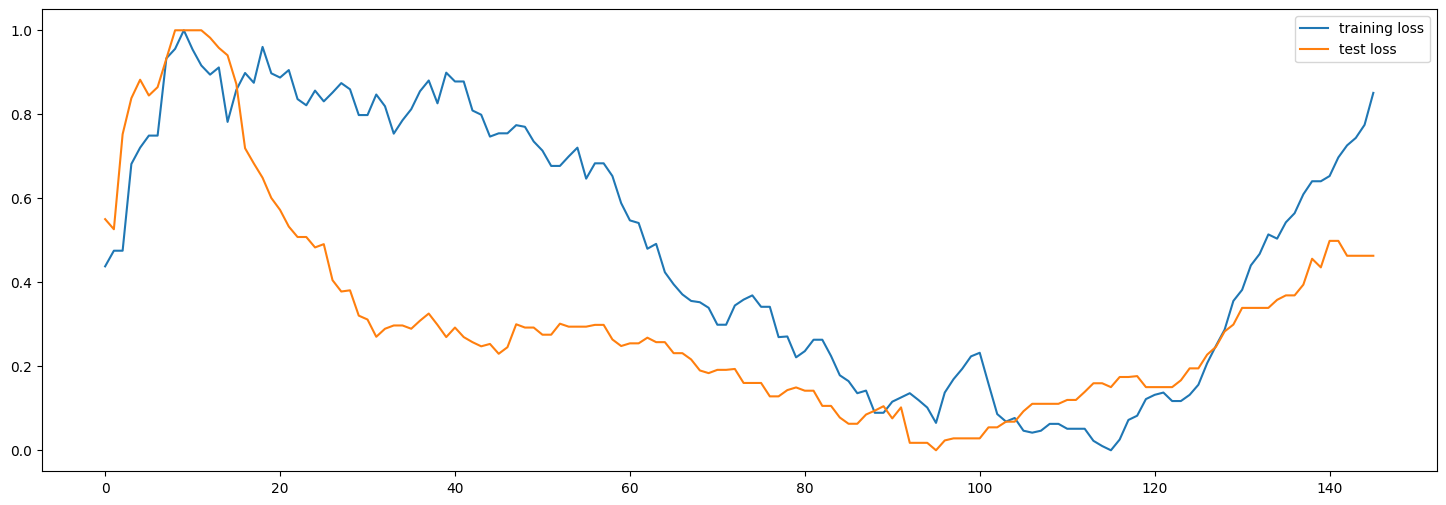

In [72]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = MoodyGBM(truths, n_estimators = 200, loss_type = 'dtw', split_size = 960, excluded_subject = test_subject, model_type = 'gbdt', learning_rate = 0.01)
mod.fit()
mse, hr_err, hr_err_sq = mod.eval()

print(f'MSE: {mse}')
print(f'Peaks error: {hr_err}')
print(f'Peaks error squared: {hr_err_sq}')

mod.plot_loss()

True HR: 55.20766773162939; Pred HR: 42.1978021978022


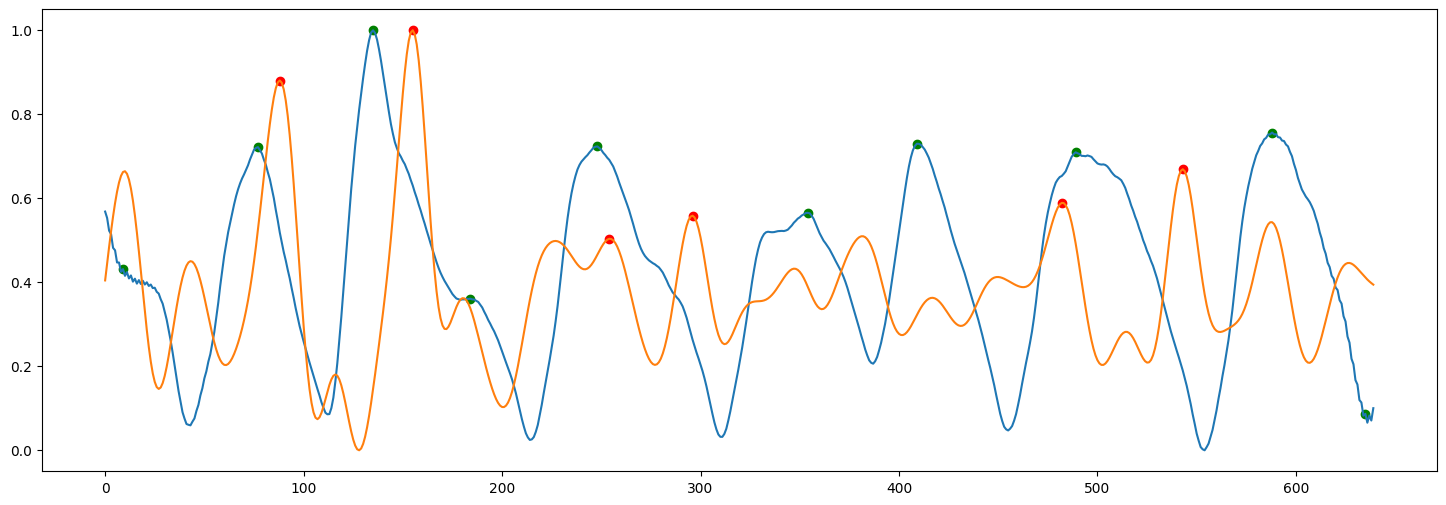

In [73]:
beg = 2000
end = 2640

model = mod

data = test_subject_truth.prepare_data_for_ml()
x = data.drop(columns = ['bvp']).to_numpy()
y = data['bvp'].to_numpy()

targ = y[beg: end]
pred = model.predict(x)[beg: end]
targ, pred = _process(targ, pred)
pred = bandpass(pred, 64, [0.67, 3.0], 4)
pred = min_max_scale(pred)

pred_peaks, _ = get_predicted_peaks(pred)
true_peaks, _ = get_true_peaks(targ)

plt.plot(targ)
plt.plot(pred)
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

In [ ]:
import numpy as np

# def softmin(x, gamma):
#     return -gamma * np.log(np.sum(np.exp(-x / gamma)))

# def soft_dtw_loss(y_true, y_pred, gamma=1.0):
#     x_time_dim, y_time_dim = len(y_true), len(y_pred)
#     D = np.zeros((x_time_dim, y_time_dim))
#     E = np.zeros((x_time_dim + 1, y_time_dim + 1))
#     R = np.full((x_time_dim + 2, y_time_dim + 2), np.inf)
    
#     for i in range(x_time_dim):
#         for j in range(y_time_dim):
#             D[i, j] = (y_true[i] - y_pred[j]) ** 2

#     R[0, 0] = 0
#     for i in range(x_time_dim):
#         for j in range(y_time_dim):
#             r = np.array([R[i, j], R[i + 1, j], R[i, j + 1]])
#             R[i + 1, j + 1] = D[i, j] + softmin(r, gamma)

#     loss = R[-2, -2]
    
#     E[-1, -1] = 1
#     for i in reversed(range(x_time_dim)):
#         for j in reversed(range(y_time_dim)):
#             r_inv = np.array([R[i + 1, j + 1], R[i + 2, j + 1], R[i + 1, j + 2]])
#             E[i, j] = np.exp(-(R[i + 1, j + 1] - softmin(r_inv, gamma)) / gamma) * E[i + 1, j + 1]
            
#     gradients = np.zeros(y_time_dim)
#     hessians = np.zeros(y_time_dim)
    
#     for j in range(y_time_dim):
#         for i in range(x_time_dim):
#             gradients[j] += 2 * E[i, j] * (y_pred[j] - y_true[i])
#             hessians[j] += 2 * E[i, j] * (1 - E[i, j])
            
#     return loss, gradients, hessians


# def softmin(x, gamma):
#     return -gamma * np.log(np.sum(np.exp(-x / gamma)))

# def soft_dtw_loss(y_true, y_pred, gamma=1.0):
#     x_time_dim, y_time_dim = len(y_true), len(y_pred)
#     D = np.zeros((x_time_dim, y_time_dim))
#     E = np.zeros((x_time_dim + 1, y_time_dim + 1))
#     R = np.full((x_time_dim + 2, y_time_dim + 2), np.inf)
    
#     for i in range(x_time_dim):
#         for j in range(y_time_dim):
#             D[i, j] = (y_true[i] - y_pred[j]) ** 2

#     R[0, 0] = 0
#     for i in range(x_time_dim):
#         for j in range(y_time_dim):
#             r = np.array([R[i, j], R[i + 1, j], R[i, j + 1]])
#             R[i + 1, j + 1] = D[i, j] + softmin(r, gamma)

#     loss = R[-2, -2]
    
#     E[-1, -1] = 1
#     for i in reversed(range(x_time_dim)):
#         for j in reversed(range(y_time_dim)):
#             r_inv = np.array([R[i + 1, j + 1], R[i + 2, j + 1], R[i + 1, j + 2]])
#             E[i, j] = np.exp(-(R[i + 1, j + 1] - softmin(r_inv, gamma)) / gamma) * E[i + 1, j + 1]
            
#     gradients = np.zeros(y_time_dim)
#     hessians = np.zeros(y_time_dim)
    
#     for j in range(y_time_dim):
#         for i in range(x_time_dim):
#             gradients[j] += 2 * E[i, j] * (y_pred[j] - y_true[i])
#             hessians[j] += 2 * E[i, j] * (1 - E[i, j])
    
#     return loss, gradients, hessians

# import numpy as np

def softmin(x, gamma):
    return -gamma * np.log(np.sum(np.exp(-x / gamma)))

def soft_dtw_loss(y_true, y_pred, gamma=1.0):
    x_time_dim, y_time_dim = len(y_true), len(y_pred)
    D = np.zeros((x_time_dim, y_time_dim))
    E = np.zeros((x_time_dim + 1, y_time_dim + 1))
    R = np.full((x_time_dim + 2, y_time_dim + 2), np.inf)
    
    for i in range(x_time_dim):
        for j in range(y_time_dim):
            D[i, j] = (y_true[i] - y_pred[j]) ** 2

    R[0, 0] = 0
    for i in range(x_time_dim):
        for j in range(y_time_dim):
            r = np.array([R[i, j], R[i + 1, j], R[i, j + 1]])
            R[i + 1, j + 1] = D[i, j] + softmin(r, gamma)

    loss = R[-2, -2]
    
    E[-1, -1] = 1
    for i in reversed(range(x_time_dim)):
        for j in reversed(range(y_time_dim)):
            r_inv = np.array([R[i + 1, j + 1], R[i + 2, j + 1], R[i + 1, j + 2]])
            
            E[i, j] = np.exp(-(R[i + 1, j + 1] - softmin(r_inv, gamma)) / gamma) * E[i + 1, j + 1]
            
    gradients = np.zeros(y_time_dim)
    hessians = np.zeros((y_time_dim, y_time_dim))
    
    for j in range(y_time_dim):
        for i in range(x_time_dim):
            gradients[j] += 2 * E[i, j] * (y_pred[j] - y_true[i])
            for k in range(y_time_dim):
                hessians[j, k] += 2 * E[i, j] * E[i, k] * (1 - (j == k))
                
    return loss, gradients, hessians


# Example usage
y_true = np.array([0, 1, 2])
y_pred = np.array([0.5, 1.5, 2.5])

loss, gradients, hessians = soft_dtw_loss(y_true, y_pred)
print("Loss:", loss)
print("Gradients:", gradients)
print("Hessians:", hessians)


In [ ]:
y_true = np.array([0.5, 1.5, 2.5])
y_pred = np.array([0.5, 1.5, 2.5])

_, gradients, hessians = soft_dtw_loss(y_true, y_pred)
print("Gradients:", gradients)
print("Hessians:", hessians)

assert np.allclose(gradients, np.zeros(3))
assert np.allclose(hessians, np.zeros((3, 3)))

In [ ]:

def soft_dtw_loss_grad(y_true, y_pred, gamma=1.0):
    n = len(y_true)
    m = len(y_pred)
    
    R = np.zeros((n + 1, m + 1))
    D = np.zeros((n + 1, m + 1))
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            D[i, j] = (y_true[i - 1] - y_pred[j - 1]) ** 2
            R[i, j] = D[i, j] + np.min([R[i - 1, j], R[i, j - 1], R[i - 1, j - 1] - gamma])
    
    E = np.zeros((n + 1, m + 1))
    E[-1, -1] = 1
    
    for i in range(n, 0, -1):
        for j in range(m, 0, -1):
            a = np.exp((R[i - 1, j] - R[i, j] - D[i - 1, j]) / gamma)
            b = np.exp((R[i, j - 1] - R[i, j] - D[i, j - 1]) / gamma)
            c = np.exp((R[i - 1, j - 1] - R[i, j] - D[i - 1, j - 1]) / gamma)
            E[i - 1, j] += a * E[i, j]
            E[i, j - 1] += b * E[i, j]
            E[i - 1, j - 1] += c * E[i, j]
    
    gradients = (E[:-1, 1:] * D[1:, 1:]).sum(axis=1) / E[0, 0]
    
    return R[-1, -1] / 2, gradients

# Test the function
y_true = np.array([1, 2, 3])
y_pred = np.array([1.5, 2.5, 3.5])

loss, gradients = soft_dtw_loss_grad(y_true, y_pred, gamma=1.0)
print("Loss:", loss)
print("Gradients:", gradients)


In [ ]:
import numpy as np

def soft_dtw_loss_grad(y_true, y_pred, gamma=1.0):
    n = len(y_true)
    m = len(y_pred)
    
    R = np.full((n + 2, m + 2), np.inf)
    D = np.zeros((n + 1, m + 1))

    R[1, 1] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            D[i, j] = (y_true[i - 1] - y_pred[j - 1]) ** 2
            R[i + 1, j + 1] = D[i, j] + np.min([R[i, j + 1], R[i + 1, j], R[i, j] - gamma])

    E = np.zeros((n + 2, m + 2))
    E[-1, -1] = 1

    for i in range(n, 0, -1):
        for j in range(m, 0, -1):
            a = np.exp((R[i, j + 1] - R[i + 1, j + 1] - D[i, j]) / gamma)
            b = np.exp((R[i + 1, j] - R[i + 1, j + 1] - D[i, j]) / gamma)
            c = np.exp((R[i, j] - R[i + 1, j + 1] - D[i, j]) / gamma)

            E[i, j + 1] += a * E[i + 1, j + 1]
            E[i + 1, j] += b * E[i + 1, j + 1]
            E[i, j] += c * E[i + 1, j + 1]

    gradients = 2 * ((E[2:-1, 2:-1] - E[1:-2, 1:-2]) * (y_pred - y_true[:, np.newaxis])).sum(axis=0) / E[1, 1]

    return R[-1, -1] / 2, gradients

# Test the function
y_true = np.array([1, 2, 3])
y_pred = np.array([1, 2, 3])

loss, gradients = soft_dtw_loss_grad(y_true, y_pred, gamma=1.0)
print("Loss:", loss)
print("Gradients:", gradients)



